# О AUC-ROC

В рамках данного ноутбука, я для себя хочу разобрать способ построения и разные детали, связанные с метрикой. При написании ноутбука, я буду сильно опираться на [статью Александра Геннадьевича про AUC-ROC](https://dyakonov.org/2017/07/28/auc-roc-%D0%BF%D0%BB%D0%BE%D1%89%D0%B0%D0%B4%D1%8C-%D0%BF%D0%BE%D0%B4-%D0%BA%D1%80%D0%B8%D0%B2%D0%BE%D0%B9-%D0%BE%D1%88%D0%B8%D0%B1%D0%BE%D0%BA/). 

Для начала, скажем, что AUC-ROC -- это мера, характеризующая качество классификации алгоритма. Данная функция (AUC-ROC) должна ставить в соответствие одинаковым наборам предсказанных и эталонных значений, одинаковые числовые значения. В противном случае, это была бы странная мера.
 
Для демонстрации сгенерируем выборку из 10 элементов и сделаем рассчёт AUC-ROC для этой выборки. Для каждого элемента сгенериуем пару $(pred, label)$, где $label$ -- метка класса, $pred$ -- предсказанное значение. Будем считать, что $pred$ -- предсказанное значение, $label$ -- метка класса.

Давайте на примере покажем, в чём суть AUC-ROC, для начала, не вдаваясь в детали. А затем, разберём ряд тонкостей. Начнём с метода построения AUC-ROC.  Поскольку способ подсчёта прост, опишем его как формальную процедуру, без вложения в неё какого бы то ни было смысла. После разбора алгоритма, перейдём к проработке деталей.

In [1]:
import pandas as pd
import numpy as np

from matplotlib.colors import LinearSegmentedColormap
from matplotlib import pyplot as plt
import seaborn as sns

from tqdm import tqdm_notebook

from sklearn.metrics import accuracy_score, roc_auc_score

fontsize = 18

In [2]:
n = 10
np.random.seed(42 * 2)
df = pd.DataFrame(index=range(n))
df['pred'] = np.random.rand(n)
df['label'] = np.uint(np.random.rand(n) > 0.5)
df

,pred,label
0,0.046041,0
1,0.370242,0
2,0.242318,1
3,0.628480,0
4,0.990110,1
5,0.130588,1
6,0.173589,1
7,0.258314,1
8,0.418399,1
9,0.131019,0


Сделаем упрощенную процедуру вычисления AUC-ROC, которую будем называть AUC-ROC\*. А затем, укажем на недостатки и введём корректировки.

Формальная процедура рассчёта AUC-ROC\* состоит в следующем: 

1. Отсортировать пары $(pred, label)$ по убыванию по $pred$. После чего, следует перебирать объекты в порядке убывания $pred$, при этом подсчитывая для каждого нуля, число единиц, находящихся перед ним в упорядоченном списке. Обозначим эту величину как $X$.
2. Подсчитать число единиц и число нулей и перемножить значения. Обозначим эту величину как $Y$.
3. Рассчитать отношение $\dfrac{X}{Y}$. Такую величину назовём AUC-ROC\*.

In [3]:
df.sort_values('pred').iloc[::-1]

,pred,label
4,0.990110,1
3,0.628480,0
8,0.418399,1
1,0.370242,0
7,0.258314,1
2,0.242318,1
6,0.173589,1
9,0.131019,0
5,0.130588,1
0,0.046041,0


Напишем алгоритм, который производит эти действия. Сделаем это нативно, без использования numpy, чтобы явно проиллюстрировать алгоритм:

In [4]:
def AUC_ROC_mod(df):
    estimates = [list(l) for l in list(df.values)]
    ones = 0
    zeros = 0
    numerator = 0
    for estimate in estimates:
        if estimate[1] == 1:
            ones += 1
            continue
        zeros += 1
        numerator += ones
    return numerator / (ones * zeros)

df = df.sort_values('pred').iloc[::-1]
print('AUC-ROC*: %f' % AUC_ROC_mod(df))

AUC-ROC*: 0.583333


В данном случае у нас есть некоторая вольность в вычислении ROC-AUC\*, которая может приводить к тому, что мы будем получать различные значения алгоритма в ряде случаев. Для того, чтобы это продемонстрировать эту особенность, давайте в столбце $pred$ укажем несколько одинаковых значений:

In [5]:
df['pred'].at[6] = df['pred'].loc[2]
df['pred'].at[9] = df['pred'].loc[2]
df = df.sort_values('pred').iloc[::-1]
df

,pred,label
4,0.990110,1
3,0.628480,0
8,0.418399,1
1,0.370242,0
7,0.258314,1
9,0.242318,0
6,0.242318,1
2,0.242318,1
5,0.130588,1
0,0.046041,0


Теперь рассмотрим те объекты, у которых в столбце pred стоят одинаковые значения. В силу того, что мы не оговариваем способ сортировки в случае равенства значений в столбце pred, оказывается, что значения AUC-ROC\* могут быть различными, при различных подходах: в рамках группы одинаковых объектов по pred мы вольны выбирать порядок. Приведём пример.

In [6]:
df.loc[9], df.loc[6] = df.loc[6].copy(), df.loc[9].copy()
df['label'] = df['label'].astype(np.uint)
df

,pred,label
4,0.990110,1
3,0.628480,0
8,0.418399,1
1,0.370242,0
7,0.258314,1
9,0.242318,1
6,0.242318,0
2,0.242318,1
5,0.130588,1
0,0.046041,0


In [7]:
print('AUC-ROC*: %f' % AUC_ROC_mod(df))

AUC-ROC*: 0.541667


Как видим, значение ROC-AUC\* отличается от предыдущего, хотя ничего существенного не произошло: мы поменяли два объекта местами и это никак не должно было отразиться на качестве алгоритма. Этот эффект возникает из-за наличия групп одинаковых элементов. Исходя из здравого смысла кажется, что коль скоро алгоритм для двух объектов, которые обладают различными метками, даёт одинаковые оценки, мы не можем сказать: хорошо проведена классификация или нет.

Перед тем, как указать способ решения данной проблемы, давайте немного поговорим о том, как интерпретировать AUC-ROC и обсудим смысл данного алгоритма. 

# Интерпретация AUC-ROC

Взглянем более пристально на смысл дроби $\dfrac{X}{Y}$. В знаменателе находится число, обозначающее количество связей между 1 и 0. Это можно визуализировать двудольным графом:

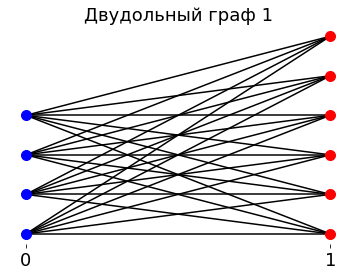

In [8]:
one = list(range(df[df['label'] == 1].shape[0]))
zero = list(range(df[df['label'] == 0].shape[0]))
fig, ax = plt.subplots()
for i in one:
    for j in zero:
        plt.plot([0, 1], [zero[j], one[i]], 'k-')
plt.plot([0] * len(zero), zero, 'bo', markersize=10)
plt.plot([1] * len(one), one, 'ro', markersize=10)
plt.xticks([0, 1], fontsize=fontsize)
plt.yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.title('Двудольный граф 1', fontsize=fontsize);

Давайте обозначим долю графа, которая содержит 0 как долю $U_0$, а долю, которая содержит 1 как долю $V_1$. Поставим в соответствие каждой вершине оценку, данную алгоритмом, и, после этого, согласно нашему алгоритму, оставим только те связи, для которых  $f(u) \leq f(v)$, где $u \in U_0, v \in V_1$

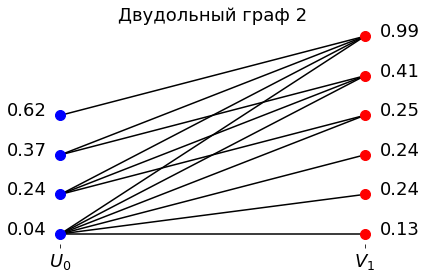

In [9]:
one = list(df[df['label'] == 1]['pred'].values)[::-1]
zero = list(df[df['label'] == 0]['pred'].values)[::-1]
fig, ax = plt.subplots()
for i in range(len(one)):
    for j in range(len(zero)):
        if zero[j] < one[i]:
            plt.plot([0, 1], [j, i], 'k-')

for i, val in enumerate(zero):
    plt.text(-0.175, i, s=str(val)[:4], fontsize=fontsize)
for i, val in enumerate(one):
    plt.text(1+0.05, i, s=str(val)[:4], fontsize=fontsize)
plt.plot([0] * len(zero), list(range(len(zero))), 'bo', markersize=10)
plt.plot([1] * len(one), list(range(len(one))), 'ro', markersize=10)
plt.xticks([0, 1], ['$U_0$', '$V_1$'], fontsize=fontsize)
plt.yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.title('Двудольный граф 2', fontsize=fontsize);

Фактически, задавая на графе оценки, полученные при помощи алгоритма, мы вводим ограничение. При этом, изначально двудольный граф задаётся только лишь тестовой выборкой и никак не зависит от алгоритма.

Мы можем представить граф матрицей:

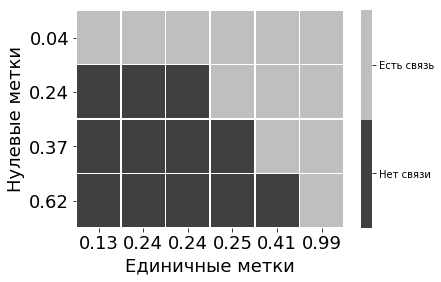

In [10]:
def PlotConnMatrix(df):
    one = list(df[df['label'] == 1]['pred'].values)[::-1]
    zero = list(df[df['label'] == 0]['pred'].values)[::-1]
    connections = np.zeros((len(zero), len(one)))
    for i in range(len(one)):
        for j in range(len(zero)):
            if zero[j] < one[i]:
                connections[j, i] = 1
    connections = pd.DataFrame(connections, dtype=np.uint, index=[str(x)[:4] for x in zero], columns=[str(x)[:4] for x in one])

    colors = ((0.25, 0.25, 0.25), (.75, .75, .75))
    cmap = LinearSegmentedColormap.from_list('Custom', colors, len(colors))
    ax = sns.heatmap(connections, linewidth=0.5, cmap=cmap)
    plt.yticks(rotation=0, fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.ylabel('Нулевые метки', fontsize=fontsize)
    plt.xlabel('Единичные метки', fontsize=fontsize)
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([0, 1])
    colorbar.set_ticks([0.25, 0.75])
    colorbar.set_ticklabels(['Нет связи', 'Есть связь'])

PlotConnMatrix(df)

Исходя из проделанных построений, можно сделать несколько выводов:

* Наша мера задана в [ранговой шкале](https://ru.wikipedia.org/wiki/%D0%A8%D0%BA%D0%B0%D0%BB%D0%B0), а значит для нашей [матрицы связей](https://www.twirpx.com/file/283458/), которая задаёт AUC-ROC\* не страшны преобразования масштабирования и сдвига. Всё это говорит о том, что AUC-ROC\* инвариантен к преобразованиям сдвига и масштаба. Например, [Задача 1](https://dyakonov.org/2015/10/09/%D0%B7%D0%B0%D0%B4%D0%B0%D1%87%D0%BA%D0%B8-%D0%BF%D1%80%D0%BE-auc-roc/) именно про это.
* Из наших построений прямо следует вероятностная интерпретация. Всё пространство объектов -- это полный двудольный граф 1. При этом граф 2, который был построен вторым, задаёт подпространство, характеризующее долю верно упорядоченных объектов. Тогда можем сказать, что AUC-ROC характеризует возможность алгоритма верно упорядочивать объекты. Или по-другому: "вероятность того, что случайно взятый объект класса 1 имеет оценку принадлежности к классу 1 выше, чем случайно взятый объект класса 0." (можно прочитать [здесь](https://dyakonov.org/2017/07/28/auc-roc-%D0%BF%D0%BB%D0%BE%D1%89%D0%B0%D0%B4%D1%8C-%D0%BF%D0%BE%D0%B4-%D0%BA%D1%80%D0%B8%D0%B2%D0%BE%D0%B9-%D0%BE%D1%88%D0%B8%D0%B1%D0%BE%D0%BA/) и [здесь](https://habr.com/company/ods/blog/328372/)). В таком случае, данная мера может с успехом применяться в задачах ранжирования.
* Следует отметить, что любой алгоритм $a_0$ можно сравить с любым дургим алгоритмом $a_1$, сравнивая их вероятности, поскольку сравнение происходит в рамках одного вероятностного пространства. Записать это легко так $P(a_0) \leq P(a_1)$  или $P(a_0) > P(a_1)$. В данном случае, важно, что сравнение качества алгоритмов происходит на одинаковой выборке, в рамках одного графа. Если же валидационные выборки различные, то мы не можем просто так сравнить два алгоритма (с формальной точки зрения это будет некорректно), поскольку в нашей интерпретации, сравнение будет происходить уже в разных пространствах.
* AUC-ROC не зависит от масштаба. Но кажется, что масштаб может играть роль. Очевидно, что значения, которые стоят первыми в отсортированном списке, важнее, ровно как и значения, которые стоят последними. Они важнее, поскольку находятся дальше от границы между классами. Но данная мера это никак не учитывает, что искажает оценку в ряде задач. В таком случае, требуется модифицировать AUC-ROC так, чтобы масштаб учитывался.

**Вопрос: как быть, если мы хотим сравнить алгоритмы, которые тестировались на различных выборках. В таком случае, возможно, нам поможет умение сравнивать ранговые разбиения. Это может оказаться важным, например, в случае, когда мы проводим валидацию на различных фолдах.**

Можно заметить, что в матрице у нас есть одинаковые оценки в строках и в столбцах. Давайте теперь вернёмся к проблеме неоднозначности в данной задаче.

# Модификация AUC-ROC* до AUC-ROC

Как говорилось выше, у нас есть некоторая вольность при выборе способа сортировки. Давайте избавимся от этого и будем сортировать оценки и метки классов сначала по pred, а затем по label. Продемонстрируем то, что у нас получится, если по-разному подходить к сортировке. Наиоблее разумными кажутся два подхода: 

* Сортировать пары (pred, label) по убыванию pred, а затем по возрастанию label (в случае равенства $pred_i$ и $pred_j$)
* Сортировать пары (pred, label) по убыванию pred, а затем по убыванию label (в случае равенства $pred_i$ и $pred_j$)

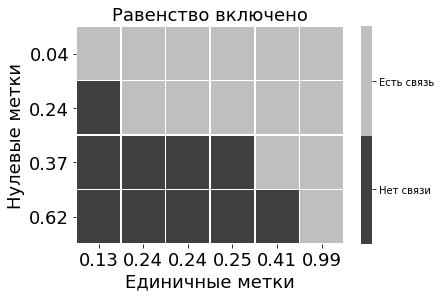

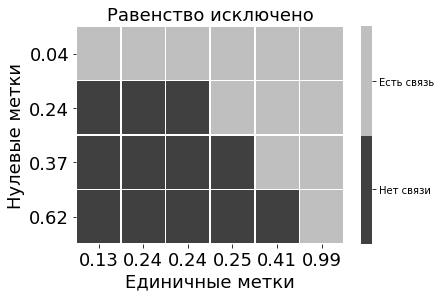

In [11]:
def PlotConnMatrixEq(df, eq=False):
    one = list(df[df['label'] == 1]['pred'].values)[::-1]
    zero = list(df[df['label'] == 0]['pred'].values)[::-1]
    connections = np.zeros((len(zero), len(one)))
    for i in range(len(one)):
        for j in range(len(zero)):
            if zero[j] < one[i] or zero[j] == one[i] and eq:
                connections[j, i] = 1
    connections = pd.DataFrame(connections, dtype=np.uint, index=[str(x)[:4] for x in zero], columns=[str(x)[:4] for x in one])

    colors = ((0.25, 0.25, 0.25), (.75, .75, .75))
    cmap = LinearSegmentedColormap.from_list('Custom', colors, len(colors))
    ax = sns.heatmap(connections, linewidth=0.5, cmap=cmap)
    plt.yticks(rotation=0, fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.ylabel('Нулевые метки', fontsize=fontsize)
    plt.xlabel('Единичные метки', fontsize=fontsize)
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([0, 1])
    colorbar.set_ticks([0.25, 0.75])
    colorbar.set_ticklabels(['Нет связи', 'Есть связь']);

PlotConnMatrixEq(df, True)
plt.title('Равенство включено', fontsize=fontsize)

plt.figure()
PlotConnMatrixEq(df, False)
plt.title('Равенство исключено', fontsize=fontsize);

Таким образом, в первом случае, мы будем считать, что все объекты, для которых метки различны, упорядочены верно, а во втором случае мы будем считать, что все объекты, для которых метки различны, упорядочены неверно. И тот, и другой способ даёт перекос. Логичнее брать такого типа объекты с весом 0.5. Назовём такие связи связи-0.5:

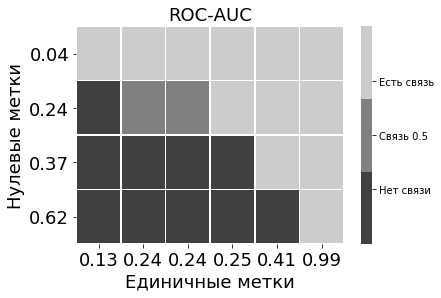

In [12]:
def PlotConnMatrix0_5(df, is_show=True):
    one = list(df[df['label'] == 1]['pred'].values)[::-1]
    zero = list(df[df['label'] == 0]['pred'].values)[::-1]
    connections = np.zeros((len(zero), len(one)))
    for i in range(len(one)):
        for j in range(len(zero)):
            if zero[j] < one[i]:
                connections[j, i] = 1
            if zero[j] == one[i]:
                connections[j, i] = 0.5
    connections = pd.DataFrame(connections, index=[str(x)[:4] for x in zero], columns=[str(x)[:4] for x in one])

    if is_show:
        colors = ((0.25, 0.25, 0.25), (.5, .5, .5), (.8, .8, .8))
        cmap = LinearSegmentedColormap.from_list('Custom', colors, len(colors))
        ax = sns.heatmap(connections, linewidth=0.5, cmap=cmap)
        plt.yticks(rotation=0, fontsize=fontsize)
        plt.xticks(fontsize=fontsize)
        plt.ylabel('Нулевые метки', fontsize=fontsize)
        plt.xlabel('Единичные метки', fontsize=fontsize)
        colorbar = ax.collections[0].colorbar
        colorbar.set_ticks([0.25, 0.5, 0.75])
        colorbar.set_ticklabels(['Нет связи', 'Связь 0.5', 'Есть связь'])
    return connections

PlotConnMatrix0_5(df)
plt.title('ROC-AUC', fontsize=fontsize);

Таким образом, мы модифицировали AUC-ROC\* до AUC-ROC.

**Замечание**: AUC-ROC\*, в зависимости от способа сортировки, задаёт либо отношение частичного порядка, либо строгое отношение частичного порядка [Описано тут](https://neerc.ifmo.ru/wiki/index.php?title=%D0%9E%D1%82%D0%BD%D0%BE%D1%88%D0%B5%D0%BD%D0%B8%D0%B5_%D0%BF%D0%BE%D1%80%D1%8F%D0%B4%D0%BA%D0%B0).

Можно [ввести формулу](https://dyakonov.org/2017/07/28/auc-roc-%D0%BF%D0%BB%D0%BE%D1%89%D0%B0%D0%B4%D1%8C-%D0%BF%D0%BE%D0%B4-%D0%BA%D1%80%D0%B8%D0%B2%D0%BE%D0%B9-%D0%BE%D1%88%D0%B8%D0%B1%D0%BE%D0%BA/) для рассчёта значений AUC-ROC:

$\dfrac{\sum\limits_{i=1}^q\sum\limits_{j=1}^q I[y_i < y_j]I'[a_i < a_j]}{\sum\limits_{i=1}^q\sum\limits_{j=1}^q I[y_i < y_j]}$,

где 

$
I' = \begin{cases} 0, & a_i > a_j \\ 0.5, & a_i = a_j \\ 1, & a_i < a_j  \end{cases},  
I = \begin{cases} 0, & y_i \geq y_j \\ 1, & y_i < y_j  \end{cases}
$

$a_i$ -- ответ алгоритма на $i$-м примере, $y_i$ -- метка алгоритма. Как мы говорили ранее, в данной формуле очень важно случай равенства для $I'$. В противном случае, мы получим AUC-ROC\*. Вычисление данной формулы совпадает с алгоритмом, который описан выше. Если Вы попытаетесь вычислить данную формулу, избавившись от многочисленных нулей, которые присутствуют в вычислениях, то получите ровно тот алгоритм, который был приведён.

# Классический способ построения AUC-ROC

Как правило, AUC-ROC вычисляют, как площадь под кривой в осях FPR, TPR. Лично мне с этими величинами было довольно сложно смириться. Странные они какие-то и я постоянно путаю их. Для того, чтобы их расшифровать, как правило вводится таблица:

In [13]:
err = pd.DataFrame(index=['Pred 1', 'Pred 0'], columns=['Label 1', 'Label 0'])
err['Label 1'] = ['True Positive (TP)', 'False Negative (FN)']
err['Label 0'] = ['False Positive (FP)', 'True Negative (TN)']
err

,Label 1,Label 0
Pred 1,True Positive (TP),False Positive (FP)
Pred 0,False Negative (FN),True Negative (TN)


Для того, чтобы запомнить эту таблицу, нужно немного. Во-первых, следует ассоциировать Pred 1 c Positive, а Pred 0 с Negative. Таким образом, Positive и Negative -- это названием оценок для классов. Так что можно записать:

In [14]:
err.index = ['Positive', 'Negative']
err

,Label 1,Label 0
Positive,True Positive (TP),False Positive (FP)
Negative,False Negative (FN),True Negative (TN)


True и False стоят на главной и побочной диагоналях и характеризуют правильность предсказания. True обозначает классы правильно предсказанных объектов (положительный и отрицательны), False -- неправильно.

Исходя из этих определений, можно построить FPR и TPR:

$FPR = \dfrac{FP}{FP+TN}$ -- доля ошибочно классифицированных объектов нулевого класса

$TPR = \dfrac{TP}{TP+FN}$ -- доля правильно классифицированных объектов единичного класса

Здесь следует отметить, что многие алгоритмы классификации предоставляют нам в пользование степень пренадлежности тому или иному классу. Но степень принадлежности интересна далеко не всегда, особенно в задачах классификации. Намного важнее получать информацию о принадлежности к классу точно, а не степень принадлежности. В связи с этим, за нами остаётся право выбирать пороговое значение для степени принадлежности. В зависимости от этого значения, очевидно, будет меняться как FPR, так и TPR.

Теперь давайте рассмотрим [следующий алгоритм](https://dyakonov.org/2017/07/28/auc-roc-%D0%BF%D0%BB%D0%BE%D1%89%D0%B0%D0%B4%D1%8C-%D0%BF%D0%BE%D0%B4-%D0%BA%D1%80%D0%B8%D0%B2%D0%BE%D0%B9-%D0%BE%D1%88%D0%B8%D0%B1%D0%BE%D0%BA/) вычисления AUC-ROC, исповедующий явное построение кривой. Мы с читаем, что у нас есть известные нам оценки pred и метки label. Пусть, как и раньше, мы имеем выборку (взята из примера по ссылке):

In [15]:
df = pd.DataFrame()
df['pred'] = [0.6, 0.5, 0.3, 0.2, 0.2, 0.1, 0]
df['label'] = [1, 0, 1, 0, 1, 0, 0]
df = df.sort_values('pred').iloc[::-1]
df

,pred,label
0,0.6,1
1,0.5,0
2,0.3,1
4,0.2,1
3,0.2,0
5,0.1,0
6,0.0,0


Алгоритм:

* Нарисуем единичный квадрат. Разобьём его на n блоков по вертикали и m блоков по горизонтали, где (n -- число нулей, m -- число единиц среди меток классов). 
* Как и в предыдущем алгоритме, отсортируем наши объекты по pred.
* Теперь будем просматривать строки таблицы сверху вниз и прорисовывать на сетке линии, переходя их одного узла в другой.
* Если значение метки класса в просматриваемой строке 1, то делаем шаг вверх; если 0, то делаем шаг вправо.
* Если у нескольких объектов значения оценок равны, то мы делаем шаг в точку, которая на a блоков выше и b блоков правее, где a – число единиц в группе объектов с одним значением метки, b – число нулей в ней. Имеено эта деталь позволяет избежать проблемы, которая была описана в предыдущем блоке.

Детальный разбор этого метода можно найти [здесь](https://dyakonov.org/2017/07/28/auc-roc-%D0%BF%D0%BB%D0%BE%D1%89%D0%B0%D0%B4%D1%8C-%D0%BF%D0%BE%D0%B4-%D0%BA%D1%80%D0%B8%D0%B2%D0%BE%D0%B9-%D0%BE%D1%88%D0%B8%D0%B1%D0%BE%D0%BA/). Нам же важно понять, почему данный алгоритм эквивалентен первой процедуре.  На самом деле, это легко продемонстрировать при помощи матрицы, которую мы рассматривали выше. Она в точности повторяет ROC-кривую. Продемонстрируем это:

0.7916666666666666

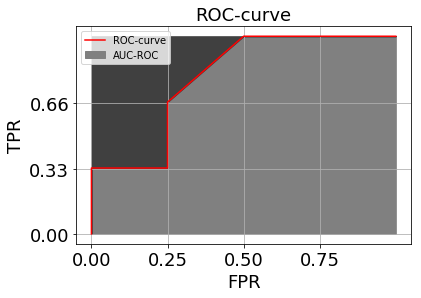

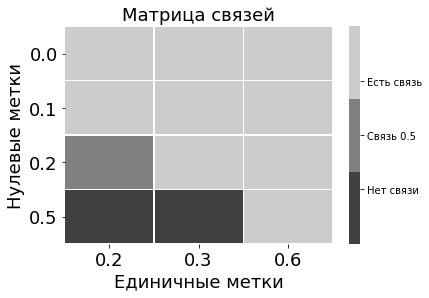

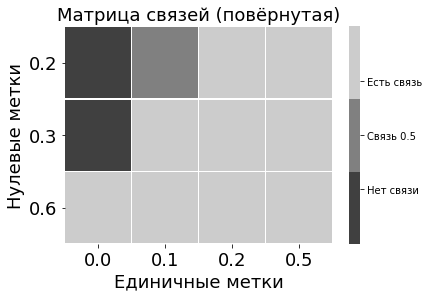

In [16]:
def PlotConnMatrix0_5_rotate(df, is_show=True):
    one = list(df[df['label'] == 1]['pred'].values)[::-1]
    zero = list(df[df['label'] == 0]['pred'].values)[::-1]
    connections = np.zeros((len(one), len(zero)))
    for i in range(len(one)):
        for j in range(len(zero)):
            if zero[j] < one[i]:
                connections[i, len(zero)-1-j] = 1
            if zero[j] == one[i]:
                connections[i, len(zero)-1-j] = 0.5
    connections = pd.DataFrame(connections, index=[str(x)[:4] for x in one], columns=[str(x)[:4] for x in zero])

    if is_show:
        colors = ((0.25, 0.25, 0.25), (.5, .5, .5), (.8, .8, .8))
        cmap = LinearSegmentedColormap.from_list('Custom', colors, len(colors))
        ax = sns.heatmap(connections, linewidth=0.5, cmap=cmap)
        plt.yticks(rotation=0, fontsize=fontsize)
        plt.xticks(fontsize=fontsize)
        plt.ylabel('Нулевые метки', fontsize=fontsize)
        plt.xlabel('Единичные метки', fontsize=fontsize)
        colorbar = ax.collections[0].colorbar
        colorbar.set_ticks([0.25, 0.5, 0.75])
        colorbar.set_ticklabels(['Нет связи', 'Связь 0.5', 'Есть связь'])
    return connections


def PlotROC_curve(df):
    y_step = 1. / df[df['label'] == 1].shape[0]
    x_step = 1. / df[df['label'] == 0].shape[0]

    x = 0
    x_prev = 0
    y = 0
    y_prev = 0
    prev_pred = -1
    roc_curve_x = [x_prev]
    roc_curve_y = [y_prev]
    auc_roc = 0
    for row in df.iterrows():
        if prev_pred != row[1]['pred']:
            
            roc_curve_x.append(x)
            roc_curve_y.append(y)
            auc_roc += (x - x_prev) * (y + y_prev) * 0.5
            
            x_prev = x
            y_prev = y
        if row[1]['label'] == 1:
            y = y + y_step
        else:
            x = x + x_step
        prev_pred = row[1]['pred']
    
    roc_curve_x.append(x)
    roc_curve_y.append(y)
    auc_roc += (x - x_prev) * (y + y_prev) * 0.5
    
    plt.plot(roc_curve_x, roc_curve_y, 'r-')
    plt.fill_between(x=roc_curve_x, y1=roc_curve_y, y2=[0] * len(roc_curve_x), color=(0.5,0.5,0.5))
    plt.fill_between(x=roc_curve_x, y1=[1] * len(roc_curve_x), y2=roc_curve_y, color=(0.25,0.25,0.25))
    plt.grid()
    plt.xlabel('FPR', fontsize=fontsize)
    plt.ylabel('TPR', fontsize=fontsize)
    plt.xticks([float(str(val)[:4]) for val in list(np.arange(0, 1, x_step))], fontsize=fontsize)
    plt.yticks([float(str(val)[:4]) for val in list(np.arange(0, 1, y_step))], fontsize=fontsize)
    plt.title('ROC-curve', fontsize=fontsize)
    plt.legend(['ROC-curve', 'AUC-ROC'])
    return auc_roc
    
auc_roc = PlotROC_curve(df)
plt.figure()
PlotConnMatrix0_5(df)
plt.title('Матрица связей', fontsize=fontsize);
plt.figure()
PlotConnMatrix0_5_rotate(df)
plt.title('Матрица связей (повёрнутая)', fontsize=fontsize);
auc_roc

Как легко наблюдать, ROC-кривая и контур, который образуют клетки матрицы (если её повернуть по часовой стрелке) совпадают с точностью до одной одной связи-0.5. Она отвечает той части ROC-кривой, которая идёт под наклоном.

Фактически, и в том, и в другом случае нам требуется вычислить "площадь". В одном случае она называется площадью под кривой. В другом случае она вычисляется при помощи подсчёта числа клеток. Если во втором случае количество клеток нормировать на их общее число (что мы и делаем, рассчитывая дробь $\dfrac{X}{Y}$ выше), то получим ровно то, что и в случае ROC-кривой.

**Замечание**: с вычислительной точки зрения, разумеется, намного эффективнее второй способ вычисления. Его алгоритмическая сложность равна $O(n)$, где $n$ -- число объектов в выборке. Второй способ выполняется за $O(n^2)$. С точки зрения понимания алгоритма, следует обратиться к первому. Для того, чтобы убедиться в том, что есть осознание, что к чему, лучше, конечно, провести мысленно или письменно соответствие между обоими способами вычисления меры.

# Бинарный случай AUC-ROC

Поскольку я довольно долго разбирался с бинарным случаем для AUC-ROC, то я решил вынести его в отдельный блок. 

Выше обсуждалось, что AUC-ROC не зависит от "порога бинаризации", в случае, если конкретный алгоритм выдаёт оценки принадлежности к классам. AUC-ROC агрегирует их в себе. При этом, в процессе вычисления AUC-ROC, мы перебираем все пороги (они равны оценкам, которые выдал алгоритм). На самом деле не то, чтобы все, а только те, которые влияют на TPR и FPR. Давайте вернёмся к самому первому рассмотренному нами примеру:

In [17]:
n = 10
np.random.seed(42 * 2)
df = pd.DataFrame(index=range(n))
df['pred'] = np.random.rand(n)
df['label'] = np.uint(np.random.rand(n) > 0.5)

df['pred'].at[6] = df['pred'].loc[2]
df['pred'].at[9] = df['pred'].loc[2]
df = df.sort_values('pred').iloc[::-1]
df

,pred,label
4,0.990110,1
3,0.628480,0
8,0.418399,1
1,0.370242,0
7,0.258314,1
9,0.242318,0
6,0.242318,1
2,0.242318,1
5,0.130588,1
0,0.046041,0


Построим ROC-curve и рассмотрим её детально. Проделаем следующий эксперимент: будем рассматривать каждую точку в ROC-curve и одновременно строить матрицу ошибок и на основе неё будем вычислять TPR и FPR:

,Label 1,Label 0
Pred 1,TP,FP
Pred 0,FN,TN


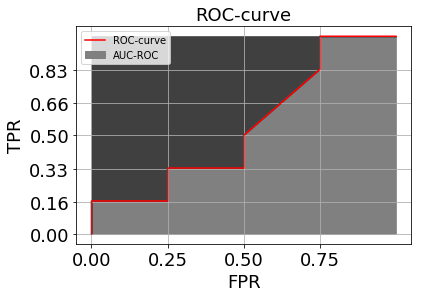

In [18]:
err = pd.DataFrame(index=['Pred 1', 'Pred 0'], columns=['Label 1', 'Label 0'])
err['Label 1'] = ['TP', 'FN']
err['Label 0'] = ['FP', 'TN']
PlotROC_curve(df);
err

Давайте ручками построим ROC-curve. Стартуем из точки $(0, 0)$. Этой точке соответствует объект с id=4 (он же первый в отсортированной выше таблице). В таком случае, неявно мы задаём порог бинаризации, равный $0.990110 + \epsilon$, где $\epsilon > 0$ (т.е. мы выбираем порог больший, чем $0.990110$). Тогда рассчитаем матрицу ошибок, TPR, FPR и продемонстрируем бинаризованую по этому порогу таблицу:

TPR    0.0
FPR    0.0
dtype: float64


,pred,label,pred_bin
4,0.990110,1,0
3,0.628480,0,0
8,0.418399,1,0
1,0.370242,0,0
7,0.258314,1,0
9,0.242318,0,0
6,0.242318,1,0
2,0.242318,1,0
5,0.130588,1,0
0,0.046041,0,0


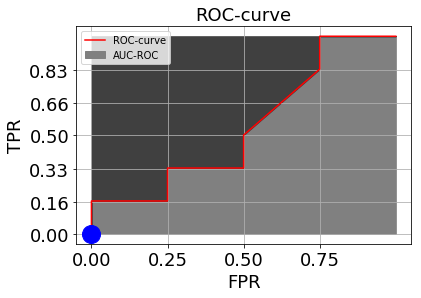

In [19]:
def BinaryErrMatrix(df):
    TP = df[(df['pred_bin'] == df['label']) & (df['label'] == 1)].shape[0]
    TN = df[(df['pred_bin'] == df['label']) & (df['label'] == 0)].shape[0]
    FP = df[(df['pred_bin'] != df['label']) & (df['label'] == 1)].shape[0]
    FN = df[(df['pred_bin'] != df['label']) & (df['label'] == 0)].shape[0]
    err = pd.DataFrame(index=['Pred 1', 'Pred 0'], columns=['Label 1', 'Label 0'])
    err['Label 1'] = [TP, FP]
    err['Label 0'] = [FN, TN]
    return err

df_t = df.copy(deep=True)
df_t['pred_bin'] = (df['pred'] > df['pred'].iloc[0]).astype(np.uint)

err = BinaryErrMatrix(df_t)
rate = err.loc['Pred 1'] / err.sum()
rate.index = ['TPR', 'FPR']
print(rate)

PlotROC_curve(df)
plt.plot(0., 0., 'bo', markersize=18)
df_t

In [20]:
err

,Label 1,Label 0
Pred 1,0,0
Pred 0,6,4


Идём дальше. Шагаем в точку $(0; 0.16)$. Этой точке соответствует объект с id=3 (он же второй в отсортированной выше таблице). В таком случае, неявно мы задаём порог бинаризации, равный $0.628480 + \epsilon$, где $\epsilon > 0$ (т.е. мы выбираем порог больший, чем $0.628480$). Тогда рассчитаем матрицу ошибок, TPR, FPR и продемонстрируем бинаризованую по этому порогу таблицу:

TPR    0.166667
FPR    0.000000
dtype: float64


,pred,label,pred_bin
4,0.990110,1,1
3,0.628480,0,0
8,0.418399,1,0
1,0.370242,0,0
7,0.258314,1,0
9,0.242318,0,0
6,0.242318,1,0
2,0.242318,1,0
5,0.130588,1,0
0,0.046041,0,0


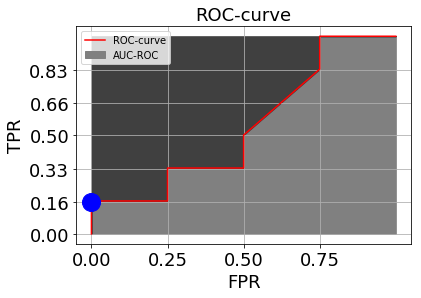

In [21]:
df_t = df.copy(deep=True)
df_t['pred_bin'] = (df['pred'] > df['pred'].iloc[1]).astype(np.uint)

err = BinaryErrMatrix(df_t)
rate = err.loc['Pred 1'] / err.sum()
rate.index = ['TPR', 'FPR']
print(rate)

PlotROC_curve(df)
plt.plot(0., 0.16, 'bo', markersize=18)

df_t

In [22]:
err

,Label 1,Label 0
Pred 1,1,0
Pred 0,5,4


Шагаем в точку $(0.25; 0.16)$. Этой точке соответствует объект с под id=8 (он же третий в отсортированной выше таблице). В таком случае, неявно мы задаём порог бинаризации, равный $0.418399 + \epsilon$, где $\epsilon > 0$ (т.е. мы выбираем порог больший, чем $0.418399$). Тогда рассчитаем матрицу ошибок, TPR, FPR и продемонстрируем бинаризованую по этому порогу таблицу:

TPR    0.166667
FPR    0.250000
dtype: float64


,pred,label,pred_bin
4,0.990110,1,1
3,0.628480,0,1
8,0.418399,1,0
1,0.370242,0,0
7,0.258314,1,0
9,0.242318,0,0
6,0.242318,1,0
2,0.242318,1,0
5,0.130588,1,0
0,0.046041,0,0


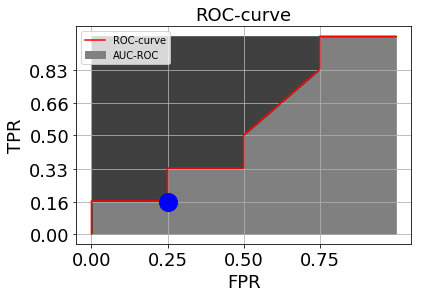

In [23]:
df_t = df.copy(deep=True)
df_t['pred_bin'] = (df['pred'] > df['pred'].iloc[2]).astype(np.uint)

err = BinaryErrMatrix(df_t)
rate = err.loc['Pred 1'] / err.sum()
rate.index = ['TPR', 'FPR']
print(rate)

PlotROC_curve(df)
plt.plot(0.25, 0.16, 'bo', markersize=18)

df_t

In [24]:
err

,Label 1,Label 0
Pred 1,1,1
Pred 0,5,3


Шагаем в точку $(0.25; 0.33)$. Этой точке соответствует объект с под id=1 (он же четвёртый в отсортированной выше таблице). В таком случае, неявно мы задаём порог бинаризации, равный $0.370242 + \epsilon$, где $\epsilon > 0$ (т.е. мы выбираем порог больший, чем $0.370242$). Тогда рассчитаем матрицу ошибок, TPR, FPR и продемонстрируем бинаризованую по этому порогу таблицу:

TPR    0.333333
FPR    0.250000
dtype: float64


,pred,label,pred_bin
4,0.990110,1,1
3,0.628480,0,1
8,0.418399,1,1
1,0.370242,0,0
7,0.258314,1,0
9,0.242318,0,0
6,0.242318,1,0
2,0.242318,1,0
5,0.130588,1,0
0,0.046041,0,0


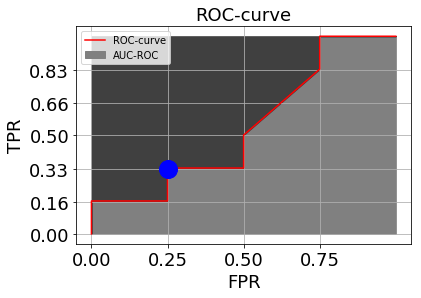

In [25]:
df_t = df.copy(deep=True)
df_t['pred_bin'] = (df['pred'] > df['pred'].iloc[3]).astype(np.uint)

err = BinaryErrMatrix(df_t)
rate = err.loc['Pred 1'] / err.sum()
rate.index = ['TPR', 'FPR']
print(rate)

PlotROC_curve(df)
plt.plot(0.25, 0.33, 'bo', markersize=18)

df_t

In [26]:
err

,Label 1,Label 0
Pred 1,2,1
Pred 0,4,3


И так далее. Мы можем таким образом построить всю кривую. И просчитать все требуемые значения.

Какой вывод отсюда следует? В каждой точке мы используем некоторое пороговое значение для построения кривой. Но кривая этого значения не хранит, если её задавать не параметрически, а в виде:

$\text{ROC-curve}(\text{FPR})=\text{TPR}(\text{FPR})$

Если же кривую задать параметрически, то в качестве изменяемого параметра, можно использовать порог бинаризации. Тогда имеем:

$
\text{ROC-curve}(p)=
\begin{cases}
x(p), & p\in[0,1] \\
y(p), & p\in[0,1]
\end{cases}
$

Все пороговые значения для данной выборки не нужны в силу дискретности задачи (это видно из построений). Например, значение 0.12345 не нужно, так как его не было в предсказанных значениях и роли оно никакой не сыграет. Следует отметить, что в непрерывном случае, принимаются во внимание все пороговые значения. Об этом будет сказано ниже, в следующем разделе.

Теперь давайте построим для каждого порога бинаризации свою ROC-curve. Мы же это можем сделать? Да, конечно. Нам нужно предположить, что наш оцениваемый алгоритм, вместо степеней принадлежности к классам выдаёт точные значения принадлежностей: 1 или 0. В таком случае, ровно также, как и раньше, мы можем построить ROC-curve для каждого порогового значения. Сделаем это:

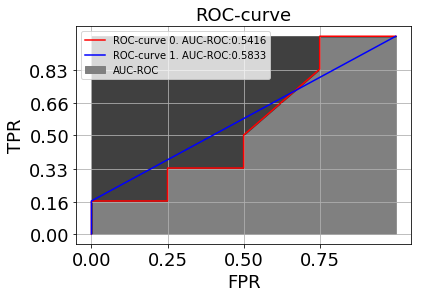

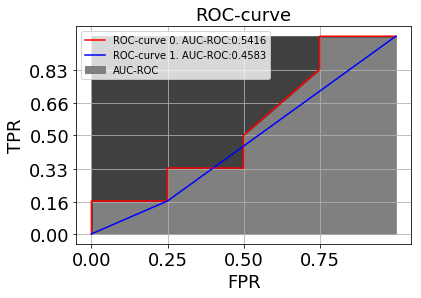

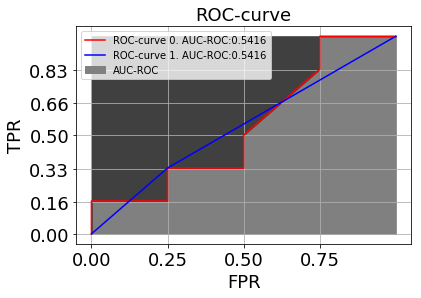

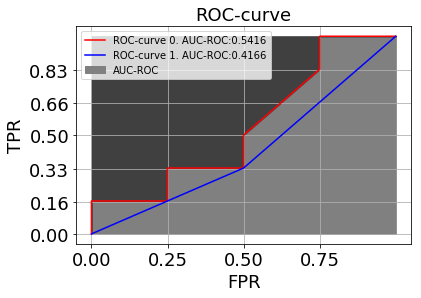

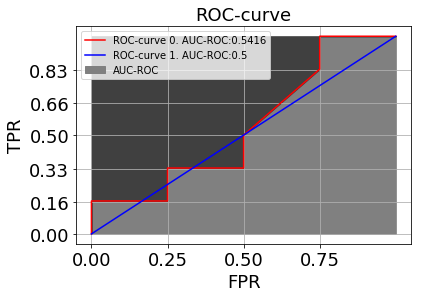

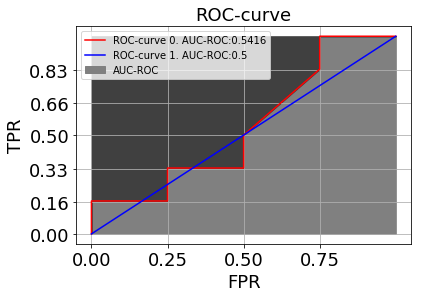

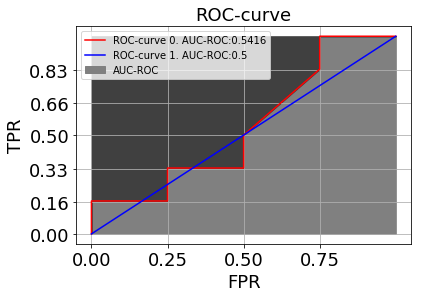

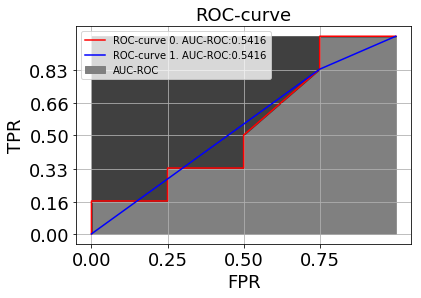

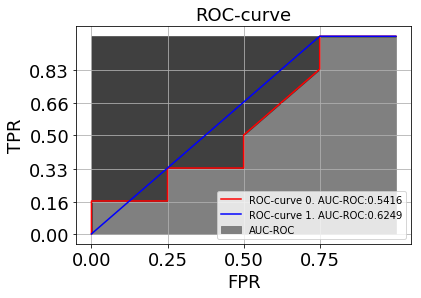

In [27]:
def PlotROC_curve_slice(df_slice, colors, is_draw=True):
    legend = []
    auc_rocs = []
    for ind, df in enumerate(df_slice):
        y_step = 1. / df[df['label'] == 1].shape[0]
        x_step = 1. / df[df['label'] == 0].shape[0]

        x = 0
        x_prev = 0
        y = 0
        y_prev = 0
        prev_pred = -1
        roc_curve_x = [x_prev]
        roc_curve_y = [y_prev]
        auc_roc = 0
        for row in df.iterrows():
            if prev_pred != row[1]['pred']:

                roc_curve_x.append(x)
                roc_curve_y.append(y)
                auc_roc += (x - x_prev) * (y + y_prev) * 0.5

                x_prev = x
                y_prev = y
            if row[1]['label'] == 1:
                y = y + y_step
            else:
                x = x + x_step
            prev_pred = row[1]['pred']

        roc_curve_x.append(x)
        roc_curve_y.append(y)
        auc_roc += (x - x_prev) * (y + y_prev) * 0.5

        if is_draw:
            plt.plot(roc_curve_x, roc_curve_y, colors[ind]+'-')
        legend.append('ROC-curve ' + str(ind) + '. AUC-ROC:' + str(auc_roc)[:6])
        if ind == 0 and is_draw:
            plt.fill_between(x=roc_curve_x, y1=roc_curve_y, y2=[0] * len(roc_curve_x), color=(0.5,0.5,0.5))
            plt.fill_between(x=roc_curve_x, y1=[1] * len(roc_curve_x), y2=roc_curve_y, color=(0.25,0.25,0.25))
        auc_rocs.append(auc_roc)
    
    if is_draw:
        legend.append('AUC-ROC')
        plt.grid(True)
        plt.xlabel('FPR', fontsize=fontsize)
        plt.ylabel('TPR', fontsize=fontsize)
        plt.xticks([float(str(val)[:4]) for val in list(np.arange(0, 1, x_step))], fontsize=fontsize)
        plt.yticks([float(str(val)[:4]) for val in list(np.arange(0, 1, y_step))], fontsize=fontsize)
        plt.title('ROC-curve', fontsize=fontsize)
        plt.legend(legend)
    return auc_rocs

auc_rocs = []
for i in range(1, df.shape[0]):
    plt.figure()
    df_t = df.copy(deep=True)
    df_t['pred'] = (df['pred'] > df['pred'].iloc[i]).astype(np.uint)
    df_t = df_t.sort_values('pred').iloc[::-1];
    auc_rocs.append(PlotROC_curve_slice([df, df_t], colors=['r', 'b']))

В каждой точке, мы можем рассчитать точно значение AUC-ROC для бинарного случая. [Здесь](https://github.com/Dyakonov/PZAD/blob/master/PZAD2018_05_minfunc_08.pdf) и [здесь](https://dyakonov.org/2017/07/28/auc-roc-%D0%BF%D0%BB%D0%BE%D1%89%D0%B0%D0%B4%D1%8C-%D0%BF%D0%BE%D0%B4-%D0%BA%D1%80%D0%B8%D0%B2%D0%BE%D0%B9-%D0%BE%D1%88%D0%B8%D0%B1%D0%BE%D0%BA/) указано, как это сделать:

$\text{AUC-ROC} = \dfrac{1 - FPR + TPR}{2} = \dfrac{1}{2}\Big(\dfrac{TN}{TN+FP} + \dfrac{TP}{TP+FN}\Big)$

Если рассмотреть последнюю часть выражения, то можно получить дополнительный смысл меры "Средняя [полнота](http://bazhenov.me/blog/2012/07/21/classification-performance-evaluation.html) по классам":

$\text{AUC-ROC} = \dfrac{1}{2}\Big(\dfrac{TN}{TN+FP} + \dfrac{TP}{TP+FN}\Big) = \dfrac{R_0+R_1}{2}$, где

$R_1 = \dfrac{TP}{TP+FN}$, $R_0 = \dfrac{TN}{TN+FP}$, где $R_0$, $R_1$ -- полнота для класса 0 и класса 1 соответственно.

Тогда легко предложить функционал для оптимизации:

$\text{TPR} - \text{FPR} \rightarrow \max$ -- максимизация доли верно угаданных положительных классов и минимизация доли ошибок неправильно угаданных нулевых классов. 

Вернёмся к последовательности графиков, которые мы получили выше. Различные пороги бинаризации, обеспечивают разные значения бинарного AUC-ROC (средней полноты по классам). На каждом из построенных графиков, мы имели 2 линии. Одна из них едина для всех рисунков (ROC-кривая для не бинаризованной выборки, которая изображена красным цветом). Другая -- бинаризованая (ROC-кривая для различных порогов, которая изображена синим цветом). Площадь под красным графиком константная и не меняется (AUC-ROC имеет постоянное значение). Площадь под синим графиком изменяется в зависимости от величины порога (AUC-ROC имеет изменяется). Построим AUC-ROC от каждого из порогов:

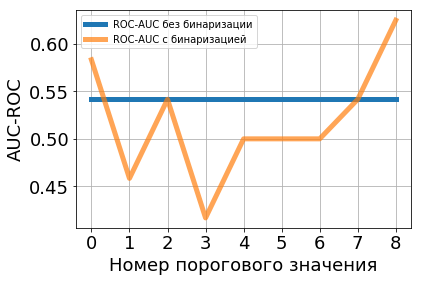

In [28]:
plt.plot(np.array(auc_rocs)[:, 0], linewidth=5)
plt.plot(np.array(auc_rocs)[:, 1], linewidth=5, alpha=0.7)
plt.grid(True)
plt.xlabel('Номер порогового значения', fontsize=fontsize)
plt.ylabel('AUC-ROC', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(['ROC-AUC без бинаризации', 'ROC-AUC с бинаризацией']);

Мы видим, что в ряде случаев бинаризация увеличивает значение AUC-ROC. В связи с этим встаёт закономерный вопрос: каким образом подобрать наиболее оптимальный порог так, чтобы AUC-ROC был наибольшим? Очевидное решение заключается в том, чтобы перебрать все пороги и выбрать самый лучший. Давайте сгенерируем достаточно большой набор данных и взглянем на результат:

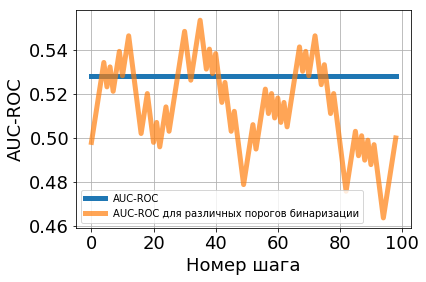

In [29]:
n = 100
np.random.seed(43 * 2)
df = pd.DataFrame(index=range(n))
df['pred'] = np.random.random(n)
df['label'] = np.uint(np.random.random(n) > 0.5)
df = df.sort_values('pred')

auc_rocs = []

for i in range(1, df.shape[0]):
    df_t = df.copy(deep=True)
    df_t['pred'] = (df['pred'] > df['pred'].iloc[i]).astype(np.uint)
    auc_rocs.append(PlotROC_curve_slice([df, df_t], colors=[], is_draw=False))

plt.plot(np.array(auc_rocs)[:, 0], linewidth=5)
plt.plot(np.array(auc_rocs)[:, 1], linewidth=5, alpha=0.7)
plt.grid(True)
plt.xlabel('Номер шага', fontsize=fontsize)
plt.ylabel('AUC-ROC', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(['AUC-ROC', 'AUC-ROC для различных порогов бинаризации']);

Найдём наилучший порог (в смысле AUC-ROC) для которого $\text{AUC-ROC}_{bin} > \text{AUC-ROC}$. Построим ROC-кривую:

In [30]:
best_threshold_ind = np.argmax(np.array(auc_rocs)[:, 1])
best_threshold = df.iloc[best_threshold_ind]['pred']

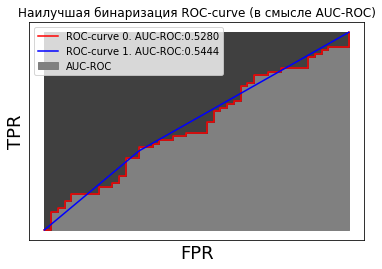

In [31]:
def PlotROC_curve_slice(df_slice, colors, is_draw=True):
    legend = []
    auc_rocs = []
    for ind, df in enumerate(df_slice):
        y_step = 1. / df[df['label'] == 1].shape[0]
        x_step = 1. / df[df['label'] == 0].shape[0]

        x = 0
        x_prev = 0
        y = 0
        y_prev = 0
        prev_pred = -1
        roc_curve_x = [x_prev]
        roc_curve_y = [y_prev]
        auc_roc = 0
        for row in df.iterrows():
            if prev_pred != row[1]['pred']:

                roc_curve_x.append(x)
                roc_curve_y.append(y)
                auc_roc += (x - x_prev) * (y + y_prev) * 0.5

                x_prev = x
                y_prev = y
            if row[1]['label'] == 1:
                y = y + y_step
            else:
                x = x + x_step
            prev_pred = row[1]['pred']

        roc_curve_x.append(x)
        roc_curve_y.append(y)
        auc_roc += (x - x_prev) * (y + y_prev) * 0.5

        if is_draw:
            plt.plot(roc_curve_x, roc_curve_y, colors[ind]+'-')
        legend.append('ROC-curve ' + str(ind) + '. AUC-ROC:' + str(auc_roc)[:6])
        if ind == 0 and is_draw:
            plt.fill_between(x=roc_curve_x, y1=roc_curve_y, y2=[0] * len(roc_curve_x), color=(0.5,0.5,0.5))
            plt.fill_between(x=roc_curve_x, y1=[1] * len(roc_curve_x), y2=roc_curve_y, color=(0.25,0.25,0.25))
        auc_rocs.append(auc_roc)
    
    if is_draw:
        legend.append('AUC-ROC')
        plt.grid(True)
        plt.xlabel('FPR', fontsize=fontsize)
        plt.ylabel('TPR', fontsize=fontsize)
        plt.xticks([float(str(val)[:4]) for val in list(np.arange(0, 1, x_step))], fontsize=fontsize)
        plt.yticks([float(str(val)[:4]) for val in list(np.arange(0, 1, y_step))], fontsize=fontsize)
        plt.title('ROC-curve', fontsize=fontsize)
        plt.legend(legend)
    return auc_rocs

df_t = df.copy(deep=True)
df_t['pred'] = (df['pred'] > best_threshold).astype(np.uint)
df_t.sort_values('pred')
PlotROC_curve_slice([df, df_t], colors=['r', 'b'])
plt.xticks([])
plt.yticks([])
plt.title('Наилучшая бинаризация ROC-curve (в смысле AUC-ROC)');
plt.grid()

Давайте проанализируем, почему мы получаем выигрыш при бинаризации. Легко заметить, что линия, соответствующая порогу бинаризации в некоторых местах пересекает красную линию. Часть площади, которая заметается красной линией, не заметается синей линией (обозначим её $R$). И наоборот, часть площади, которая заметается синей линией, не заметается красной линией (обозначим её $B$). В таком случае, нам требуется максимизировать:

$B - R \rightarrow \max$

Тогда можно получить более общую постановку задачи, когда бинаризация не представляет интерес и важна оптимизация самой метрики AUC-ROC. В этом случае, может оказаться эффективным найти несколько точек, которые следует объединить в группы и присвоить им одинаковые ранги:

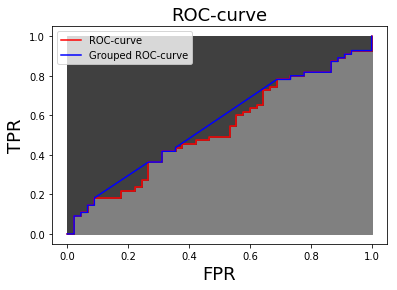

In [32]:
def PlotROC_curve_xy(df):
    y_step = 1. / df[df['label'] == 1].shape[0]
    x_step = 1. / df[df['label'] == 0].shape[0]

    x = 0
    x_prev = 0
    y = 0
    y_prev = 0
    prev_pred = -1
    roc_curve_x = [x_prev]
    roc_curve_y = [y_prev]
    auc_roc = 0
    for row in df.iterrows():
        if prev_pred != row[1]['pred']:
            
            roc_curve_x.append(x)
            roc_curve_y.append(y)
            
            x_prev = x
            y_prev = y
        if row[1]['label'] == 1:
            y = y + y_step
        else:
            x = x + x_step
        prev_pred = row[1]['pred']
    
    roc_curve_x.append(x)
    roc_curve_y.append(y)
    
    return roc_curve_x, roc_curve_y

x, y = PlotROC_curve_xy(df)
plt.plot(x, y, 'r-')
plt.fill_between(x=x, y1=y, y2=[0] * len(x), color=(0.5,0.5,0.5))
plt.fill_between(x=x, y1=[1] * len(x), y2=y, color=(0.25,0.25,0.25))
plt.xlabel('FPR', fontsize=fontsize)
plt.ylabel('TPR', fontsize=fontsize)
plt.title('ROC-curve', fontsize=fontsize)
start0 = 16
finish0 = 33
start1 = 42
finish1 = 75
plt.plot(x[:start0] + x[finish0:start1] + x[finish1:], y[:start0] + y[finish0:start1] + y[finish1:], 'b')
plt.legend(['ROC-curve', 'Grouped ROC-curve']);

При грамотно подобранных порогах, можно существенно повысить значение метрики. Но нужно понимать, что если это делать без ансамблирования, то мы с большой вероятностью переучимся.

В этом разделе для меня остаются открытыми следующие вопросы:

* Как выбирать пороги и как производить объединение значений
* Каким образом связана ROC-кривая общего вида со средней полнотой по классам и функционалом $\text{TPR} - \text{FPR} \rightarrow \max$
* Каким образом связана сгруппированная ROC-кривая со средней полнотой по классам и функционалом $\text{TPR} - \text{FPR} \rightarrow \max$
* Что означают кривые, у которых есть явные ямы и горбы (очевидно, это значит, что в для определённых порогов качество упорядочивания падает)

# Взвешенный AUC-ROC для несбалансированных классов в бинарном случае

Рассмотрим бинарный случай AUC-ROC. В прошлом разделе мы получили запись вида:

$\text{AUC-ROC} = \dfrac{R_0 + R_1}{2}$

Тогда, коль скоро, размеры классов не равны, можем, взвесить $R_0$ и $R_1$ следующим образом. Пусть $M_0$, $M_1$ -- мощность 0 и 1 классов соответственно. Тогда, можем ввести поправочные коэффициенты:

$\alpha_0 = \dfrac{M_1}{M_0 + M_1}$, $\alpha_1 = \dfrac{M_0}{M_0 + M_1}$

Получим 

$\text{AUC-ROC}_{\text{weight}} = \dfrac{\alpha_0R_0 + \alpha_1R_1}{2}$

В данном случае остаётся вопрос: 
* Возможно ли осуществить аналогичное преобразование для произвольного случая, а не только для бинарного

# Оптимизация AUC-ROC в узлах дерева

[Предлагается](https://github.com/Dyakonov/PZAD/blob/master/PZAD2018_05_minfunc_08.pdf) выбрать оптимизировать функционал качества в узлах дерева, который построен на мере AUC-ROC:

$|m_1 \cdot n - n_1 \cdot m| \rightarrow \max$,

при этом, m_1, n_1 -- доля объектов класса 1 и 0 в левом поддереве/правом поддереве. Из выкладок следует, что функционал зависит только от одного поддерева. Для этого реализуем дерево, чтобы явно задавать в узлах критерий качества. Для того, чтобы понять качество работы, сравним его с классическим критерием информативности Джини.

In [36]:
def djini(split):
    if float(len(split)) == 0:
        p_plus = np.Inf
    else:
        p_plus = np.sum(split == 0) / float(len(split))
    return 2 * p_plus * (1 - p_plus)


def delta_information(not_split, split1, split0):
    djini_value = djini(not_split) - \
                  len(split1) / float(len(not_split)) * djini(split1) - \
                  len(split0) / float(len(not_split)) * djini(split0)
    if np.isnan(djini_value) or np.isinf(djini_value):
        return 0
    else:
        return djini_value


def roc_metric_split_1(not_split, split1, split0):
    djini_value = np.abs(np.sum(not_split) * np.sum(1 - split1) - np.sum(1 - not_split) * np.sum(split1))
    if np.isnan(djini_value) or np.isinf(djini_value):
        return 0
    else:
        return djini_value
    


def roc_metric_split_0(not_split, split1, split0):
    djini_value = np.abs(np.sum(not_split) * np.sum(1 - split0) - np.sum(1 - not_split) * np.sum(split0))
    if np.isnan(djini_value) or np.isinf(djini_value):
        return 0
    else:
        return djini_value


class Tree:
    def __init__(self, loss=delta_information, threshold=0.5, max_depth=5, min_leaf_sample=10):
        self.max_depth = max_depth
        self.min_leaf_sample = min_leaf_sample
        self.threshold = threshold
        self.loss = loss
        self.root = Node(residual_depth=max_depth, min_leaf_sample=min_leaf_sample, threshold=threshold, loss=loss)

    def depth_search(self, current_node, x):
        if current_node.right_node is None or current_node.left_node is None:
            return current_node.class_label
        value = x[current_node.optimal_feature_index]
        predicted_value = current_node.optimal_clf.predict_proba([value])
        if predicted_value[0] > self.threshold:
            class_label = self.depth_search(current_node.left_node, x)
        else:
            class_label = self.depth_search(current_node.right_node, x)
        return class_label

    def lr_search(self, current_node, x, y, depth):
        y_left, x_left, y_right, x_right = current_node.splitter(x, y)
        current_node.class_label = np.uint8(np.mean(y) > self.threshold)
        if not (y_left is None or x_left is None or y_right is None or x_right is None):
            current_node.left_node = Node(residual_depth=self.max_depth - depth, min_leaf_sample=self.min_leaf_sample,
                                          threshold=self.threshold, loss=self.loss)
            current_node.right_node = Node(residual_depth=self.max_depth - depth, min_leaf_sample=self.min_leaf_sample,
                                           threshold=self.threshold, loss=self.loss)
            self.lr_search(current_node.left_node, x_left, y_left, depth + 1)
            self.lr_search(current_node.right_node, x_right, y_right, depth + 1)

    def fit(self, x, y):
        self.lr_search(self.root, x, y, 0)
        return self

    def predict(self, x):
        answer = []
        for row in x:
            class_label = self.depth_search(self.root, row)
            answer.append(class_label)
        return np.array(answer)

    def score(self, x, y):
        return roc_auc_score(y, self.predict(x))


class LinearClassifier:
    def __init__(self, loss):
        self.best_t = None
        self.loss = loss

    def fit(self, x, y):
        values = np.unique(x)
        self.best_t = values[0]
        best_value = self.loss(y, y[x > self.best_t], y[x <= self.best_t])
        for t in values[1:]:
            cur_value = self.loss(y, y[x > t], y[x <= t])
            if best_value < cur_value:
                best_value = cur_value
                self.best_t = t

    def predict_proba(self, x):
        return np.uint(x > self.best_t)


class Node:
    def __init__(self, residual_depth, min_leaf_sample, threshold=0.5, loss=delta_information):
        self.left_node = None
        self.right_node = None
        self.optimal_clf = None
        self.optimal_loss = None
        self.residual_depth = residual_depth
        self.min_leaf_sample = min_leaf_sample
        self.threshold = threshold
        self.class_label = None
        self.optimal_feature_index = None
        self.class_0 = None
        self.class_1 = None
        self.loss = loss

    def splitter(self, features, classes):
        optimal_left_set = None
        optimal_right_set = None
        self.class_0 = np.sum(np.uint8(classes == 0))
        self.class_1 = np.sum(np.uint8(classes == 1))
        if len(classes) < self.min_leaf_sample or self.residual_depth == 0 or self.class_1 == 0 or self.class_0 == 0:
            return None, None, None, None
        for index in range(0, len(features[0, :])):
            clf = LinearClassifier(self.loss)
            x = features[:, index]
            clf.fit(x, classes)
            class_labels = clf.predict_proba(x) > self.threshold
            left_set = np.where(class_labels)
            right_set = np.where(1 - class_labels)
            loss = self.loss(classes, classes[left_set], classes[right_set])
            if self.optimal_loss is None or loss > self.optimal_loss:
                self.optimal_loss = loss
                self.optimal_clf = clf
                optimal_left_set = left_set
                optimal_right_set = right_set
                self.optimal_feature_index = index
        if self.optimal_loss > 0:
            return classes[optimal_left_set], features[optimal_left_set], \
                   classes[optimal_right_set], features[optimal_right_set]
        else:
            return None, None, None, None

Проверим адекватность реализации на модельной задачи с двумя нормальными распределениями в 100 элементов с указанным функционалом:

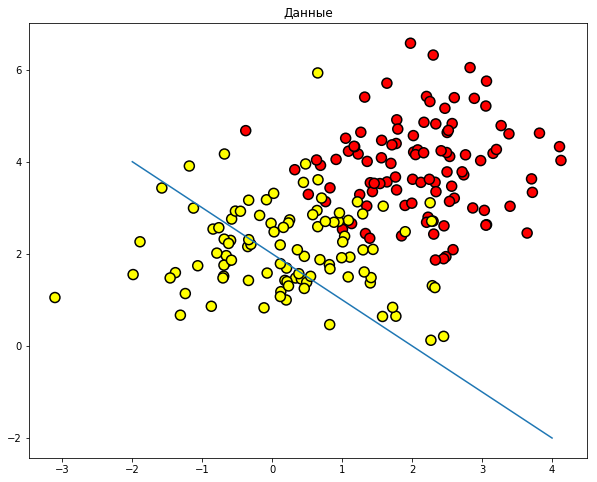

In [37]:
n = 100
seed = 42
features = 2
v = 2.4
np.random.seed(seed)

def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

x = np.random.normal(size=(n, features)) + v * np.random.rand(features)
y = np.zeros(n)

x = np.r_[x, np.random.normal(size=(n, features))] + v * np.random.rand(features)
y = np.r_[y, np.ones(n)]

plt.rcParams['figure.figsize'] = (10, 8)
plt.scatter(x[:, 0], x[:, 1], c=y, s=100, cmap='autumn', edgecolors='black', linewidth=1.5)
plt.plot(range(-2,5), range(4,-3,-1))
plt.title('Данные');

Проверим адекватность реализации на модельной задачи с двумя нормальными распределениями в 100 элементов с критерием информативности Джини:

AUC-ROC: 0.98


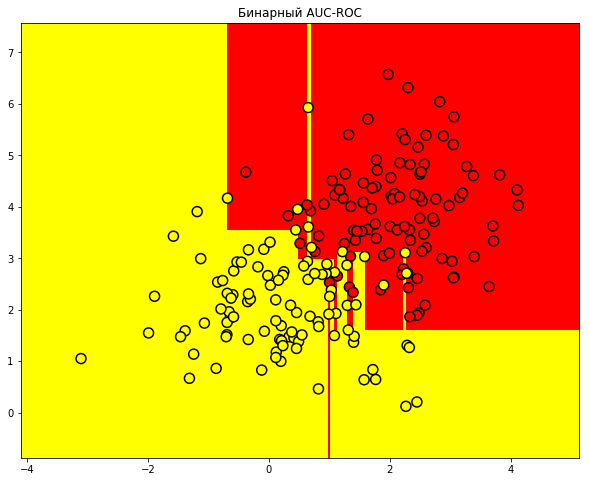

In [38]:
max_depth = 10
min_leaf_sample = 5

tree = Tree(max_depth=max_depth, min_leaf_sample=min_leaf_sample, loss=roc_metric_split_1)
tree.fit(x, y)

print('AUC-ROC:', tree.score(x, y))

xx, yy = get_grid(x)
predicted = tree.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, predicted, cmap='autumn')
plt.scatter(x[:, 0], x[:, 1], c=y, s=100, cmap='autumn', edgecolors='black', linewidth=1.5)
plt.title('Бинарный AUC-ROC');

AUC-ROC: 0.98


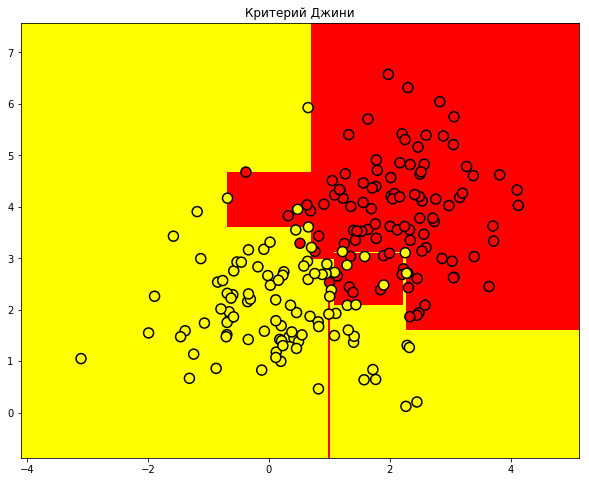

In [39]:
tree = Tree(max_depth=max_depth, min_leaf_sample=min_leaf_sample, loss=delta_information)
tree.fit(x, y)

xx, yy = get_grid(x)
predicted = tree.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, predicted, cmap='autumn')
plt.scatter(x[:, 0], x[:, 1], c=y, s=100, cmap='autumn', edgecolors='black', linewidth=1.5)
print('AUC-ROC:', tree.score(x, y))
plt.title('Критерий Джини');

Как видим, существенной разницы не наблюдается, если смотреть на разделяющую поверхность. Проделаем два эксперимента (для двух конфигураций деревьев):

In [41]:
max_depth = 20
min_leaf_sample = 10

roc_score = []
djini_score = []
n = 500
v = 2.4
features = 2
for seed in tqdm_notebook(range(30)):
    np.random.seed(seed)
    x = np.random.normal(size=(n, features)) + v * np.random.rand(features)
    y = np.zeros(n)

    # добавляем второй класс
    x = np.r_[x, np.random.normal(size=(n, features))] + v * np.random.rand(features)
    y = np.r_[y, np.ones(n)]
    
    np.random.seed(seed)
    tree = Tree(max_depth=max_depth, min_leaf_sample=min_leaf_sample, loss=roc_metric_split)
    tree.fit(x, y)
    roc_score.append(tree.score(x, y))
    np.random.seed(seed)
    tree = Tree(max_depth=max_depth, min_leaf_sample=min_leaf_sample, loss=delta_information)
    tree.fit(x, y)
    djini_score.append(tree.score(x, y))

max_depth = 10
min_leaf_sample = print('Джини', np.mean(djini_score), '. AUC-ROC:', np.mean(roc_score))


Джини 0.9245333333333332 . AUC-ROC: 0.9087999999999999


In [42]:
max_depth = 10
min_leaf_sample = 5

roc_score = []
djini_score = []
n = 500
v = 2.4
features = 2
for seed in tqdm_notebook(range(30)):
    np.random.seed(seed)
    x = np.random.normal(size=(n, features)) + v * np.random.rand(features)
    y = np.zeros(n)

    # добавляем второй класс
    x = np.r_[x, np.random.normal(size=(n, features))] + v * np.random.rand(features)
    y = np.r_[y, np.ones(n)]
    
    np.random.seed(seed)
    tree = Tree(max_depth=max_depth, min_leaf_sample=min_leaf_sample, loss=roc_metric_split)
    tree.fit(x, y)
    roc_score.append(tree.score(x, y))
    np.random.seed(seed)
    tree = Tree(max_depth=max_depth, min_leaf_sample=min_leaf_sample, loss=delta_information)
    tree.fit(x, y)
    djini_score.append(tree.score(x, y))
    
print('Джини', np.mean(djini_score), '. AUC-ROC:', np.mean(roc_score))


Джини 0.9219333333333333 . AUC-ROC: 0.9505666666666668


Если провести 30 экспериментов и посмотреть на результаты, то по средним значениям AUC-ROC, можно выдвинуть несколько предположений: 

* При малых глубинах деревьев эффективнее себя показывает бинарный критерий, максимизирующий AUC-ROC.
* При увеличении глубины деревьев, критерий информативности Джини даёт лучший результат.

Не следует забывать, что в данных экспериментах, разница между оценками может быть статистически не значимой. В связи с этим требуется детальное исследование данного вопроса.

# Вопросы, которые я плохо проработал:

* Непрерывый случай AUC-ROC
* Cohen's kappa https://stats.stackexchange.com/questions/82162/cohens-kappa-in-plain-english
* Неранговый AUC-ROC (количественный). Кажется, что в AUC-ROC логично ввести расстояние между рангами. В таком случае, быть может, мы сможем давать оценки, которые больше приближены к реальности в тех или иных случаях
* Многомерный AUC-ROC http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.98.4088&rep=rep1&type=pdf или one vs all
* Коэффициент Мэтьюса https://ru.coursera.org/lecture/stats-for-data-analysis/korrieliatsiia-met-iusa-i-koeffitsiient-kramiera-prX3S

# Источники:

* https://github.com/esokolov/ml-course-msu/blob/master/ML15/lecture-notes/Sem05_metrics.pdf
* https://dyakonov.org/2015/12/15/%D0%B7%D0%BD%D0%B0%D0%BA%D0%BE%D0%BC%D1%8C%D1%82%D0%B5%D1%81%D1%8C-%D0%B4%D0%B6%D0%B8%D0%BD%D0%B8/
* https://ld86.github.io/ml-slides/unbalanced.html#/32
* https://habr.com/post/228963/
* https://habr.com/company/ods/blog/350440/
* http://www.machinelearning.ru/wiki/images/4/4b/Kitov-ML-eng-06-Classifier_evaluation.pdf
* http://datareview.info/article/luchshaya-metrika-dlya-ocenki-tochnosti-klassifikacionnyx-modelej/
* https://docs.google.com/forms/d/e/1FAIpQLSfrZOU9TaDWIvxBabf8saK-unmijfOHwkANpARNCrVQ-g3KyQ/viewform
* https://ru.wikipedia.org/wiki/ROC-%D0%BA%D1%80%D0%B8%D0%B2%D0%B0%D1%8F
* https://habr.com/company/ods/blog/328372/
* http://ttic.uchicago.edu/~meshi/papers/structAUC_aistats14.pdf
* https://dyakonov.org/2017/07/28/auc-roc-%D0%BF%D0%BB%D0%BE%D1%89%D0%B0%D0%B4%D1%8C-%D0%BF%D0%BE%D0%B4-%D0%BA%D1%80%D0%B8%D0%B2%D0%BE%D0%B9-%D0%BE%D1%88%D0%B8%D0%B1%D0%BE%D0%BA/
* https://github.com/Dyakonov/PZAD/blob/master/PZAD2018_05_minfunc_08.pdf
* https://github.com/Dyakonov/PZAD/blob/master/PZAD2018_04_errors_22.pdf
* https://www.twirpx.com/file/283458/